# Optimal control of integrator dynamics

## Imports

In [5]:
from typing import Any, Union, NamedTuple, Callable
from functools import partial
import jax
from jax import Array
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

from diffilqrax.utils import keygen
from diffilqrax.lqr import solve_lqr
from diffilqrax.typs import (
    LQR,
    LQRParams,
    ModelDims
)

jax.config.update('jax_enable_x64', True)

## The Problem

We have simple integrator dynamics, where we want to steer the state to rest with minimal input energy.

$$
J_{k}(x_{k}) = \frac{1}{2}Q_{N} ||x_{N}||^{2} +\frac{1}{2} \sum^{N-1}_{i=k} \left(||x_{i}||^{2} + ||u_{i}||^{2} \right)
$$

The dynamics of the integrator are defined as,

$$
\left(\begin{matrix} p_{k+1} \\ v_{k+1} \end{matrix}\right) = 
\left( \begin{matrix} 1 & \delta t \\ 0 & 1 \end{matrix} \right)
\left(\begin{matrix} p_{k+1} \\ v_{k+1} \end{matrix}\right) + 
\left(\begin{matrix} \delta t \\ 0 \end{matrix}\right) u_{k}
$$



In [27]:
sys_dims = ModelDims(n=2,m=1,horizon=100, dt=0.1)

## Setting up LQR parameters

The `LQRParams` class contains parameters that contain the quadratic costs ($Q$, $Q_f$ $R$, $S$) and linear costs ($q$,$q_f$, $r$), the dynamic matrix ($A$), the input matrix ($B$), the state bias ($a$), and the initial state of the system $x_{0}$.

As this problem solves for finite horizon, the parameters need to span along the length of the horizon, and
$Q$ and $R$ need to be semi-positive definite (i.e. the diagonal components >= 0). 

In [28]:
# Define time invariant LQR problem
A = jnp.array([[1., 1.*sys_dims.dt], [0., 1.]])
B = jnp.array([[0.5*sys_dims.dt**2], [sys_dims.dt]])
# B = jnp.array([[0.5*sys_dims.dt**2, 0],
#                [sys_dims.dt, 0]])
a = jnp.zeros(sys_dims.n)
Q = jnp.eye(sys_dims.n)
q = jnp.zeros(sys_dims.n)
R = jnp.eye(sys_dims.m)
r = jnp.zeros(sys_dims.m)
S = jnp.zeros((sys_dims.n, sys_dims.m))
Qf = jnp.eye(sys_dims.n)
qf = jnp.zeros(sys_dims.n)

# Span along the horizon
span_mat = partial(jnp.tile, reps=(sys_dims.horizon,1,1))
span_vec = partial(jnp.tile, reps=(sys_dims.horizon,1))

# Define LQR problem through time
lqr_mats = LQR(
    A=span_mat(A),
    B=span_mat(B),
    a=span_vec(a),
    Q=span_mat(Q),
    q=span_vec(q),
    R=span_mat(R),
    r=span_vec(r),
    S=span_mat(S),
    Qf=Qf,
    qf=qf
)
lqr_mats?

Signature:      lqr_mats()
Type:           LQR
String form:   
LQR(A=Array([[[1. , 0.1],
           [0. , 1. ]],
           
           [[1. , 0.1],
           [0. , 1. ]],
           
           <...> loat64), Qf=Array([[1., 0.],
           [0., 1.]], dtype=float64), qf=Array([0., 0.], dtype=float64))
Length:         10
File:           ~/VSCodeProjects/ilqr_vae_jax/diffilqrax/typs.py
Docstring:     
LQR params

Attributes
----------
A : Array
    Dynamics matrix.
B : Array
    Input matrix.
a : Array
    Offset vector.
Q : Array
    State cost matrix.
q : Array
    State cost vector.
R : Array
    Input cost matrix.
r : Array
    Input cost vector.
S : Array
    Cross term matrix.
Qf : Array
    Final state cost matrix.
qf : Array
    Final state cost vector.
Call docstring:
Symmetrise quadratic costs.

Returns
-------
LQR
    Symmetrised LQR parameters.

In [29]:
# define an initial state of the system
key = jr.PRNGKey(seed=0)
k, sk = jr.split(key)
x0 = jr.normal(key, (sys_dims.n,))
# x0 = jnp.array([0., 0.])

print(f"Initial state:\n{x0}")

# Construct the LQR problem
lqr_params = LQRParams(
    x0=x0,
    lqr=lqr_mats
)

Initial state:
[ 1.81608667 -0.75488484]


## Solve LQR problem

In [34]:
opt_traj = solve_lqr(lqr_params)
opt_state, opt_input, opt_costate=opt_traj

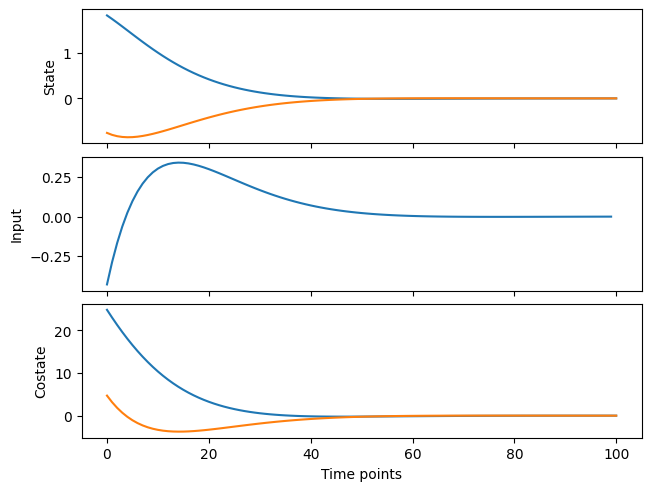

In [43]:
fig, axes = plt.subplots(3,1, layout="constrained",sharex=True)
_ = [ax.plot(opt) for ax, opt in zip(axes.flatten(), opt_traj)]
_ = [ax.set_ylabel(n) for ax, n in zip(axes.flatten(), ["State", "Input", "Costate"])]
_ = axes[-1].set_xlabel("Time points")

## Validate optimal solution with kkt conditions

In [62]:
from diffilqrax.lqr import kkt
# Validate optimal solution with KKT conditions
kkt_residuals = kkt(lqr_params, *opt_traj)

print(f"< ∂L/x > KKT residuals:\t{jnp.mean(jnp.abs(kkt_residuals[0])):.4}")
print(f"< ∂L/u > KKT residuals:\t{jnp.mean(jnp.abs(kkt_residuals[1])):.4}")
print(f"< ∂L/λ > KKT residuals:\t{jnp.mean(jnp.abs(kkt_residuals[2])):.4}")

< ∂L/x > KKT residuals:	0.0
< ∂L/u > KKT residuals:	1.807e-16
< ∂L/λ > KKT residuals:	2.198e-19


# Optimal control of integrator dynamics with tracking

With the same integrator dynamics, want to find the optimal control that can track a target trajectory. Tracking a trajectory is contained in the linear terms of the state cost function, proof shown below.

With a target trajectory $\mu$, and the system's projected state, $\hat{\mu}=Cx$. We define the state cost, $c$, as,

$$
c= (\mu-\hat{\mu})^{T}Q(\mu-\hat{\mu})
$$

Expanding the cost gives,

$$
\begin{align}
    c &= \underbrace{\mu^{T}Q\mu}_{\text{offset}} - \underbrace{\mu^{T}Q\hat{\mu}}_{\text{lin. term}} - \underbrace{\hat{\mu}^{T}Q\mu}_{\text{lin. term}} + \underbrace{\hat{\mu}^{T}Q\hat{\mu}}_{\text{quad. term}} \\
     &= \hat{\mu}^{T}Q\hat{\mu} - 2\hat{\mu}^{T}Q\mu + \mu^{T}Q\mu \\
     &= x\underbrace{C^{T}QC}_{\tilde{Q}}x + x^{T}\underbrace{(-2C^{T}Q\mu}_{\tilde{q}}) + \mu^{T}Q\mu
\end{align}
$$

note, if there is no projection, $C=\mathbb{1}$, and, $q=\tilde{q}$, the offset term is independent of the minimization so can be ignored.



In [ ]:
sys_dims = ModelDims(n=2,m=1,horizon=100, dt=0.1)

Target trajectory is a Sine wave

In [132]:
# define sin target trajectory with different frequencies
x1_targ = jnp.sin((2*jnp.pi)*jnp.linspace(0,2,sys_dims.horizon+1))
x2_targ = jnp.sin((2*jnp.pi)*jnp.linspace(0,2,sys_dims.horizon+1))
# x2_targ = jnp.sin((3/2*jnp.pi)*jnp.linspace(0,2,sys_dims.horizon+1))
x_target = jnp.stack([x1_targ, x2_targ], axis=-1)

[Text(0.5, 0, 'Time points'), Text(0, 0.5, 'Target State')]

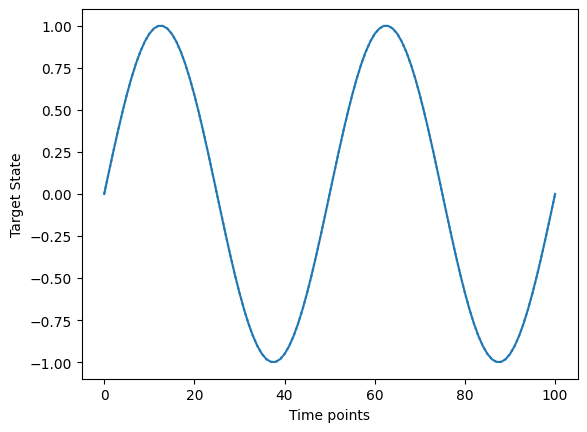

In [133]:
fig, ax = plt.subplots()
ax.plot(x_target[:,0], c="C0", ls=":", label="Target")
ax.plot(x_target[:,1], c="C0", ls="-", label="Target")
ax.set(xlabel="Time points", ylabel="Target State")

## LQR problem set-up

In [138]:
# Define time invariant LQR problem
A = jnp.array([[1., 1.*sys_dims.dt], [0., 1.]])
B = jnp.array([[0.5*sys_dims.dt**2], [sys_dims.dt]])
a = jnp.zeros(sys_dims.n)
Q = jnp.eye(sys_dims.n)
R = jnp.eye(sys_dims.m)
r = jnp.zeros(sys_dims.m)
S = jnp.zeros((sys_dims.n, sys_dims.m))
Qf = jnp.eye(sys_dims.n)

# Span along the horizon
span_mat = partial(jnp.tile, reps=(sys_dims.horizon,1,1))
span_vec = partial(jnp.tile, reps=(sys_dims.horizon,1))

# Define LQR problem through time
lqr_mats = LQR(
    A=span_mat(A),
    B=span_mat(B),
    a=span_vec(a),
    Q=span_mat(Q),
    q=-4.*x_target[:-1], # target state
    R=span_mat(R),
    r=span_vec(r),
    S=span_mat(S),
    Qf=Qf,
    qf=-4.*x_target[-1] # final target state
)

In [139]:
# define an initial state of the system
key = jr.PRNGKey(seed=0)
k, sk = jr.split(key)
# x0 = jr.normal(key, (sys_dims.n,))
x0 = jnp.array([0., 0.])

print(f"Initial state:\n{x0}")

# Construct the LQR problem
lqr_params = LQRParams(
    x0=x0,
    lqr=lqr_mats
)

Initial state:
[0. 0.]


## Solve LQR problem

In [140]:
# solve LQR
opt_traj = solve_lqr(lqr_params)
opt_state, opt_input, opt_costate=opt_traj

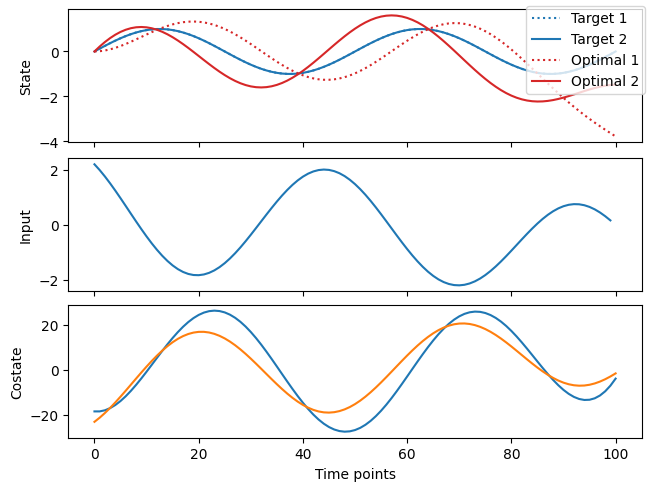

In [141]:
fig, axes = plt.subplots(3,1, layout="constrained",sharex=True)
_ = [ax.plot(opt) for ax, opt in zip(axes.flatten()[1:], opt_traj[1:])]
_ = [ax.set_ylabel(n) for ax, n in zip(axes.flatten(), ["State", "Input", "Costate"])]
_ = axes[-1].set_xlabel("Time points")

ax = axes.flatten()[0]
ax.plot(x_target[:,0], c="C0", ls=":", label="Target 1")
ax.plot(x_target[:,1], c="C0", ls="-", label="Target 2")
ax.plot(opt_traj[0][:,0], c="C3", ls=":", label="Optimal 1")
ax.plot(opt_traj[0][:,1], c="C3", ls="-", label="Optimal 2")
fig.legend()